# GRU Model

##### Step 1. Import modules and load dataset

In [2]:
pip install --upgrade tensorflow


  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl (377.0 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [1]:
# 1. Import thư viện cần thiết
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
!pip install yfinance
import yfinance as yf

ModuleNotFoundError: No module named 'tensorflow.python'

In [2]:
# Tải dữ liệu từ Yahoo Finance
bnb_data = yf.download('BNB-USD', start='2019-03-01', end='2024-06-01')
bnb_data.reset_index(inplace=True)
bnb_data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1914,2024-05-27,599.825928,613.388184,599.700745,603.526428,603.526428,1691663828
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745


In [3]:
# Chỉ sử dụng giá đóng cửa để đơn giản hóa và tính toán tỉ lệ thay đổi giữa mỗi giá trị và giá trị liền trước
time_series = bnb_data['Adj Close'].pct_change().dropna()
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
time_series=scaler.fit_transform(np.array(time_series).reshape(-1,1))

# Phân chia dữ liệu

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(time_series))
test_size = int(0.3 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Xây dựng mô hình và train

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - loss: 0.0956
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0076
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 0.0031
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.0025
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0020
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - loss: 0.0022
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 0.0027
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 0.0031
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0026
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 0.0030
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.0020
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 0.0021
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - loss: 0.0026
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - loss: 0.0034
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s

# Dự báo trên tập test / validate và đánh giá mô hình

In [9]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [10]:
# 12.1 Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)
# 12.2 Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = mean_absolute_percentage_error(y_test, y_pred) 

print('Testing MAPE:', test_mape)
# 12.3 Đánh giá độ chính xác thuật toán bằng MAE
mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', mae)

Testing RMSE: 0.37451222488127467
Testing MAPE: 0.9917301122272446
Testing MAE: 0.3737261831933094


# Dự báo 30 ngày tiếp theo

In [11]:
# 13. Dự báo 30 ngày tiếp theo dựa trên dữ liệu test
x_input = test_data[60:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0
while i < 30:

    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

[0.3778633]
517
1 day input [0.37744982 0.4225204  0.36595027 0.38729968 0.38014934 0.42017807
 0.36977603 0.39033779 0.40032233 0.38396021 0.393693   0.41035677
 0.365969   0.36616505 0.37774255 0.33693889 0.39980088 0.4060105
 0.35849776 0.38659813 0.38253333 0.36093134 0.39521632 0.36815703
 0.38483677 0.36981019 0.40770621 0.3462959  0.39070483 0.38992546
 0.39184929 0.39997208 0.37081936 0.36782798 0.36641508 0.39899715
 0.36145929 0.31487052 0.37525233 0.38891622 0.38194114 0.32245855
 0.38027343 0.43892729 0.34024342 0.40058346 0.38471457 0.36184726
 0.38515118 0.36418101 0.37903465 0.36311043 0.35646154 0.37625179
 0.39485404 0.36326851 0.36533885 0.37952643 0.36651573 0.34641936
 0.3728676  0.37278316 0.37327075 0.37927726 0.36760524 0.34539251
 0.37566949 0.37701984 0.41301202 0.43474032 0.37660017 0.36876967
 0.44156569 0.40030275 0.35531258 0.3900033  0.36449374 0.38168949
 0.33942489 0.39738671 0.35496824 0.37614226 0.39251944 0.32642462
 0.38192784 0.37693208 0.38304869 0

In [12]:
# 13. Dự báo 60 ngày tiếp theo dựa trên dữ liệu test
x_input = test_data[60:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0
while i < 60:

    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

[0.3778633]
517
1 day input [0.37744982 0.4225204  0.36595027 0.38729968 0.38014934 0.42017807
 0.36977603 0.39033779 0.40032233 0.38396021 0.393693   0.41035677
 0.365969   0.36616505 0.37774255 0.33693889 0.39980088 0.4060105
 0.35849776 0.38659813 0.38253333 0.36093134 0.39521632 0.36815703
 0.38483677 0.36981019 0.40770621 0.3462959  0.39070483 0.38992546
 0.39184929 0.39997208 0.37081936 0.36782798 0.36641508 0.39899715
 0.36145929 0.31487052 0.37525233 0.38891622 0.38194114 0.32245855
 0.38027343 0.43892729 0.34024342 0.40058346 0.38471457 0.36184726
 0.38515118 0.36418101 0.37903465 0.36311043 0.35646154 0.37625179
 0.39485404 0.36326851 0.36533885 0.37952643 0.36651573 0.34641936
 0.3728676  0.37278316 0.37327075 0.37927726 0.36760524 0.34539251
 0.37566949 0.37701984 0.41301202 0.43474032 0.37660017 0.36876967
 0.44156569 0.40030275 0.35531258 0.3900033  0.36449374 0.38168949
 0.33942489 0.39738671 0.35496824 0.37614226 0.39251944 0.32642462
 0.38192784 0.37693208 0.38304869 0

In [13]:
# 13. Dự báo 90 ngày tiếp theo dựa trên dữ liệu test
x_input = test_data[60:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = x_input.shape[1]
i = 0
while i < 90:

    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

[0.3778633]
517
1 day input [0.37744982 0.4225204  0.36595027 0.38729968 0.38014934 0.42017807
 0.36977603 0.39033779 0.40032233 0.38396021 0.393693   0.41035677
 0.365969   0.36616505 0.37774255 0.33693889 0.39980088 0.4060105
 0.35849776 0.38659813 0.38253333 0.36093134 0.39521632 0.36815703
 0.38483677 0.36981019 0.40770621 0.3462959  0.39070483 0.38992546
 0.39184929 0.39997208 0.37081936 0.36782798 0.36641508 0.39899715
 0.36145929 0.31487052 0.37525233 0.38891622 0.38194114 0.32245855
 0.38027343 0.43892729 0.34024342 0.40058346 0.38471457 0.36184726
 0.38515118 0.36418101 0.37903465 0.36311043 0.35646154 0.37625179
 0.39485404 0.36326851 0.36533885 0.37952643 0.36651573 0.34641936
 0.3728676  0.37278316 0.37327075 0.37927726 0.36760524 0.34539251
 0.37566949 0.37701984 0.41301202 0.43474032 0.37660017 0.36876967
 0.44156569 0.40030275 0.35531258 0.3900033  0.36449374 0.38168949
 0.33942489 0.39738671 0.35496824 0.37614226 0.39251944 0.32642462
 0.38192784 0.37693208 0.38304869 0

# Vẽ đồ thị

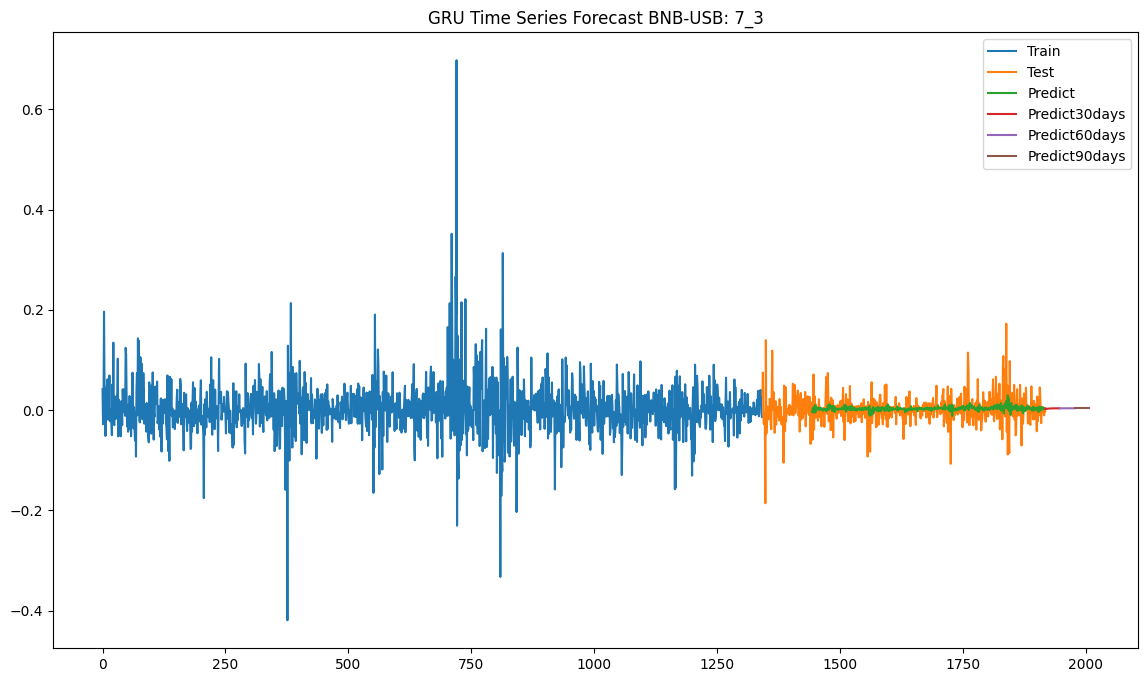

In [14]:

plt.figure(figsize=(14, 8))

# Vẽ dữ liệu huấn luyện (train_data)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Vẽ dữ liệu kiểm tra (test_data)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dữ liệu dự đoán cho tập kiểm tra (y_pred)
test_pred_index = pd.RangeIndex(start=train_size + 101, stop=train_size + len(test_data), step=1)
plt.plot(test_pred_index, y_pred, label='Predict')

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(time_series)-1, stop=len(time_series) + 29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_30), label='Predict30days')

# Vẽ dự đoán 60 ngày, bắt đầu từ len(time_series) + 30 để không bị chồng lên dự đoán 30 ngày
predict_index_60 = pd.RangeIndex(start=len(time_series)+29, stop=len(time_series) + 59, step=1)
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_60[30:]), label='Predict60days')


# Vẽ dự đoán 90 ngày, bắt đầu từ len(time_series) + 60 để không bị chồng lên dự đoán 60 ngày
predict_index_90 = pd.RangeIndex(start=len(time_series)+59, stop=len(time_series) + 89, step=1)
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90[60:]), label='Predict90days')

# Thêm chú thích và hiển thị đồ thị
plt.title('GRU Time Series Forecast BNB-USB: 7_3')
plt.legend(['Train', 'Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.show()
